# E0022_P06_Generate-final-datasets

Completed by Rebecca Poulos.

Checked on 08/04/2020.

In [1]:
source_folder = '/Users/rpoulos/Documents/E0022_Project/E0022_github_source_folder/'

### Import libraries

In [3]:
import pandas as pd
import numpy as np
from numpy import array
import scipy.stats
import random
from random import shuffle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from matplotlib import gridspec
from matplotlib import mlab
from matplotlib.ticker import ScalarFormatter
import matplotlib.patheffects as PathEffects
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor as mlpr
from sklearn.linear_model import Lasso as lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import nan_euclidean_distances
# from Bio import SeqIO
from matplotlib.patches import Patch
from datetime import datetime
import datetime as dt
from sklearn.manifold import MDS
from sklearn import linear_model
import itertools

In [4]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set(style='white', font_scale=1)

In [5]:
outline_props = dict(color='black',linewidth=1)

### Import sample mapping

In [6]:
df_sample_map = pd.read_csv('E0022_P06_final_sample_map.txt', sep='\t').set_index('Automatic_MS_filename')
dict_sample_map = df_sample_map.to_dict()
print('Number of MS files in study:',len(df_sample_map))

Number of MS files in study: 7116


In [7]:
df_cell_map = df_sample_map.drop(['Batch','Code','Daisy_chain','Date','Instrument','Replicate'], axis=1).drop_duplicates().set_index('Cell_line')
dict_cell_map = df_cell_map.to_dict()
print('Number of cell lines in study:',len(df_cell_map[lambda x: ~x.index.str.contains('Control_HEK293T')]))

Number of cell lines in study: 979


### Import raw peptide data matrix

In [9]:
df_pept_raw = pd.read_csv(source_folder+'E0022_P06_raw_peptide_matrix.csv.gz')
df_pept_raw = df_pept_raw.rename(columns={'Unnamed: 0':'index'}).set_index('index').transpose().reset_index().rename(columns={'index':'Identifier'}).set_index('Identifier').transpose()
df_pept_raw = df_pept_raw.loc[df_sample_map.index.tolist()].apply(np.log2)

### Identify shared peptides

In [ ]:
peptide_dict = {}
peptide_list = df_pept_raw.columns.tolist()
mod_peptide_list = []
for peptide in peptide_list:
    curr_peptide = peptide.split('=')[2]
    mod_peptide = curr_peptide.replace('I','X')
    mod_peptide = mod_peptide.replace('L','X')
    peptide_dict[peptide] = [curr_peptide, mod_peptide]
    mod_peptide_list.append(mod_peptide)
bad_peptides = list(set([x for x in mod_peptide_list if mod_peptide_list.count(x) > 1]))
print('Number of common peptides to be discarded due to I/L problem:',len(bad_peptides))
peptides_to_remove = []
for peptide in peptide_dict:
    for bad_peptide in bad_peptides:
        if bad_peptide in peptide_dict[peptide]:
            peptides_to_remove.append(peptide)
peptides_to_remove = list(set(peptides_to_remove))
print('Total number of peptides to be discarded due to I/L problem:',len(peptides_to_remove))

### Generate peptide datasets

In [ ]:
def finalise_peptide_dataset(dtaframe, output_file):
    dtaframe = dtaframe[[x for x in dtaframe.columns.tolist() if x not in peptides_to_remove]]
#     dtaframe.to_csv(source_folder+'final_datasets_080420/'+output_file, sep='\t', compression='gzip')
    print('Number of samples: ',dtaframe.shape[0])
    print('Number of peptides: ',dtaframe.shape[1])
    print('Missing values (%): ',format(dtaframe.isna().sum().sum()/dtaframe.size*100,'.2f'))
    return dtaframe

In [ ]:
def generate_peptide_datasets(input_dtaframe, output_diffacto_file):
    protein_df = input_dtaframe.transpose().reset_index()
    protein_df[['Protein','Peptide','ModPeptide']] = protein_df['Identifier'].str.split('=',expand=True)
    protein_df = protein_df.drop(['Identifier','ModPeptide'],axis=1).set_index('Protein').reset_index().set_index('Peptide').reset_index().rename(columns={'Peptide':'','Protein':''})
    protein_df.to_csv(source_folder+'final_datasets_080420/'+output_diffacto_file,index=False)

##### Finalise raw peptide matrix

In [10]:
df_pept_raw = finalise_peptide_dataset(df_pept_raw, 'E0022_P06_Peptide_Matrix_Raw.tsv.gz')
generate_peptide_datasets(df_pept_raw, 'Interim_E0022_P06_Peptide_Matrix_Raw_forDiffacto.txt')

Number of samples:  7116
Number of peptides:  36834
Missing values (%):  57.02


##### Import median normalised peptide matrix

In [11]:
curr_df = df_pept_raw.transpose()
overall_median = np.log2(curr_df.median().mean())
med_norm_vals = curr_df.apply(np.log2).median()-overall_median
df_pept_median = curr_df.apply(np.log2).subtract(med_norm_vals).transpose()
df_pept_median = finalise_peptide_dataset(df_pept_median, 'E0022_P06_Peptide_Matrix_Median.tsv.gz')
generate_peptide_datasets(df_pept_median, 'Interim_E0022_P06_Peptide_Matrix_Median_forDiffacto.txt')

Number of samples:  7116
Number of peptides:  36834
Missing values (%):  57.02


##### Import peptide matrix after ProNorM

In [12]:
df_pept = pd.read_csv(source_folder+'FromRUV_E0022_P06_dataset_normalised_k4_postqc.csv.gz')
df_pept = df_pept.rename(columns={'Unnamed: 0':'index'}).set_index('index').transpose().reset_index().rename(columns={'index':'Identifier'}).set_index('Identifier').transpose().dropna(how='all',axis=1)
df_pept = finalise_peptide_dataset(df_pept, 'E0022_P06_Peptide_Matrix_RUV.tsv.gz')
generate_peptide_datasets(df_pept, 'Interim_E0022_P06_Peptide_Matrix_RUV_forDiffacto.txt')

Number of samples:  7116
Number of peptides:  36806
Missing values (%):  56.99


In [13]:
df_pept_TR = pd.read_csv(source_folder+'E0022_P06_ruv_k4_qc_techRep.csv.gz', sep='\t')
df_pept_TR = df_pept_TR.rename(columns={'Unnamed: 0':'index'}).set_index('index').transpose().reset_index().rename(columns={'index':'Identifier'}).set_index('Identifier').transpose().dropna(how='all',axis=1)
df_pept_TR = finalise_peptide_dataset(df_pept_TR, 'E0022_P06_Peptide_Matrix_ProNorM.tsv.gz')
generate_peptide_datasets(df_pept_TR, 'Interim_E0022_P06_Peptide_Matrix_TR_forDiffacto.txt')

Number of samples:  7116
Number of peptides:  36806
Missing values (%):  42.80


##### Identify peptides to exclude

In [14]:
iRT_peptides = [x for x in df_pept_raw.columns.tolist() if 'RMIS' in x or 'Biognosys' in x]
non_human_peptides = [x for x in df_pept_raw.columns.tolist() if x not in iRT_peptides and '_HUMAN' not in x]
print('Number of iRT peptides:', len(iRT_peptides))
print('Number of non-human peptides:', len(non_human_peptides))
peptides_to_exclude = iRT_peptides+non_human_peptides
pd.DataFrame(index=peptides_to_exclude).reset_index().to_csv(source_folder+'final_datasets_080420/E0022_P06_peptides_to_exclude.txt', index=False, header=None, sep='\t')
proteins_to_exclude = list(set([x.split('=')[0] for x in peptides_to_exclude]))

Number of iRT peptides: 67
Number of non-human peptides: 3


### Run Diffacto

Modify the file paths below as appropriate:

python3 diffacto/diffacto.py -i source_folder+final_datasets_080420/Interim_E0022_P06_Peptide_Matrix_Raw_forDiffacto.txt -log2 True -impute_threshold 1.1 -out source_folder+final_datasets_080420/Interim_E0022_P06_Peptide_Matrix_Raw_fromDiffacto.tsv

python3 diffacto/diffacto.py -i source_folder+final_datasets_080420/Interim_E0022_P06_Peptide_Matrix_Median_forDiffacto.txt -log2 True -impute_threshold 1.1 -out source_folder+final_datasets_080420/Interim_E0022_P06_Peptide_Matrix_Median_fromDiffacto.tsv

python3 diffacto/diffacto.py -i source_folder+final_datasets_080420/Interim_E0022_P06_Peptide_Matrix_RUV_forDiffacto.txt -log2 True -impute_threshold 1.1 -out source_folder+final_datasets_080420/Interim_E0022_P06_Peptide_Matrix_RUV_fromDiffacto.tsv

python3 diffacto/diffacto.py -i source_folder+final_datasets_080420/Interim_E0022_P06_Peptide_Matrix_TR_forDiffacto.txt -log2 True -impute_threshold 1.1 -out source_folder+final_datasets_080420/Interim_E0022_P06_Peptide_Matrix_TR_fromDiffacto.tsv

### Generate protein datasets

In [15]:
def import_protein_matrix(filename, title, num, peptide_matrix):
    df_prot = pd.read_csv(filename, sep='\t')
    df_prot.loc[df_prot[lambda x: x['S/N'] == -np.inf].index.tolist(),'S/N'] = -200
    threshold = -20
    ax = fig.add_subplot(1,3,num)
    plot = sns.distplot(df_prot['S/N'], color='blue', bins=100)
    plot.axvline(x=threshold, linestyle='--', color='red', linewidth=2)
    plot.set_xlabel('S/N', weight='bold')
    plot.set_ylabel('Frequency', weight='bold')
    plot.set_title(title, fontsize=14, weight='bold')
    plot.set_xlim(-150,100)
    df_prot = df_prot[lambda x: x['S/N'] > threshold]
    df_prot = df_prot.drop(['N.Pept','Q.Pept','S/N','P(PECA)'], axis=1).set_index('Protein').transpose()
    df_prot = df_prot[[x for x in df_prot.columns.tolist() if x not in proteins_to_exclude]]
    plot.text(0.05,0.95, 'Proteins: '+str(df_prot.shape[1]), color='red', weight='bold', transform=plot.transAxes)
    plot.text(0.05,0.9, 'S/N threshold: '+str(threshold), color='red', weight='bold', transform=plot.transAxes)
    curr_df = peptide_matrix.transpose().reset_index()
    curr_df[['Protein','Peptide','ModifiedPeptide']] = curr_df['Identifier'].str.split('=', expand=True)
    curr_df = curr_df.drop(['Peptide','ModifiedPeptide','Identifier'],axis=1).groupby('Protein').count().transpose()[df_prot.columns.tolist()]
    df_prot[curr_df == 1] = np.nan
    df_prot.to_csv(source_folder+'final_datasets_080420/E0022_P06_Protein_Matrix_Replicate_'+title+'.tsv.gz', sep='\t', compression='gzip')
    df_prot_ave = df_prot.join(df_sample_map['Cell_line']).groupby('Cell_line').mean()
    plot.text(0.05,0.85, 'Missing (%): '+format(df_prot_ave.isna().sum().sum()/df_prot_ave.size*100,'.2f'), color='red', weight='bold', transform=plot.transAxes)
    plot.text(0.05,0.8, 'Total IDs: '+f'{(df_prot_ave.count().sum()):,}', color='red', weight='bold', transform=plot.transAxes)
    df_prot_ave.to_csv(source_folder+'final_datasets_080420/E0022_P06_Protein_Matrix_'+title+'.tsv.gz', sep='\t', compression='gzip')
    return df_prot_ave

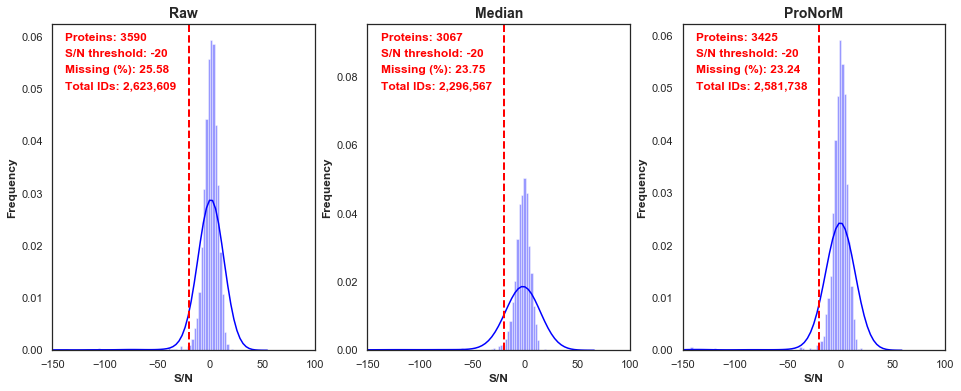

In [16]:
fig = plt.figure(figsize=[16,6])
df_prot_raw = import_protein_matrix(source_folder+'final_datasets_080420/Interim_E0022_P06_Peptide_Matrix_Raw_fromDiffacto.tsv', 'Raw', 1, df_pept_raw)
df_prot_median = import_protein_matrix(source_folder+'final_datasets_080420/Interim_E0022_P06_Peptide_Matrix_Median_fromDiffacto.tsv', 'Median', 2, df_pept_median)
df_prot = import_protein_matrix(source_folder+'final_datasets_080420/Interim_E0022_P06_Peptide_Matrix_TR_fromDiffacto.tsv', 'ProNorM', 3, df_pept_TR)
plt.show()